## Impute missing values
### Method for point gaps: fill forward (LOCF)
### Method for bigger gaps: mean of the hour the week before and after

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [14]:
# Load data
data = pd.read_csv('all_building_data.csv')
data['Time'] = pd.to_datetime(data['Time'])
data = data.set_index('Time')
#data.head()

# find columns with missing values
missing_counts = data.isnull().sum()  # Get the count of missing values for each column
columns_with_missing = missing_counts[missing_counts > 0]  # Filter columns with at least one missing value

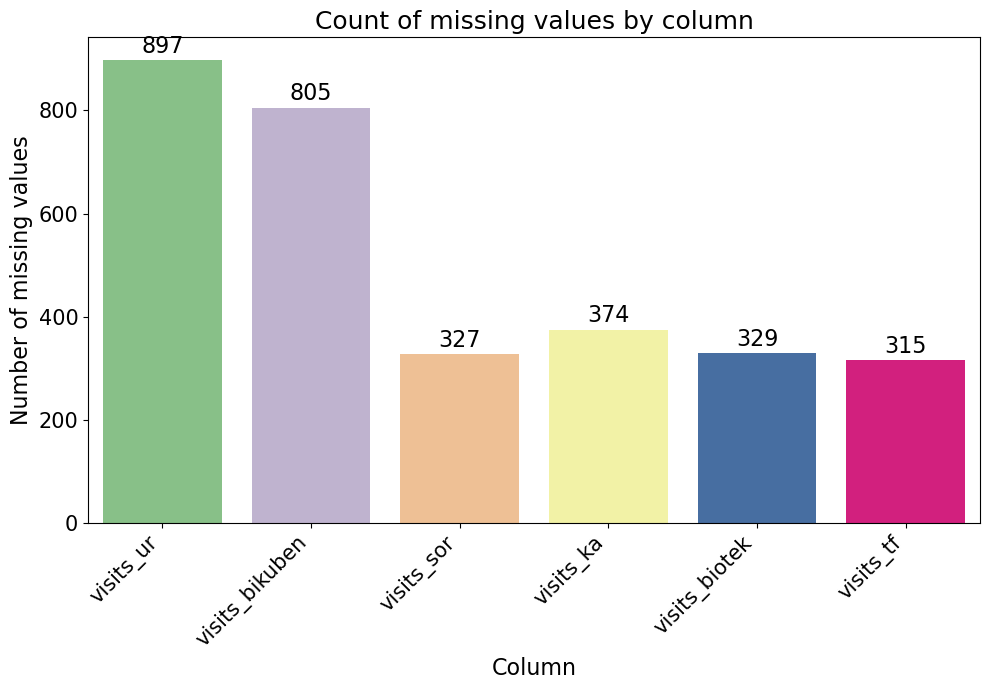

In [15]:
# plot the missing values count
plot=plt.figure(figsize=(10, 7))
ax = sns.barplot(x=columns_with_missing.index, y=columns_with_missing.values, palette='Accent', hue=columns_with_missing.index)

# show the number of missing values on top of each bar
for i, value in enumerate(columns_with_missing.values):
    ax.text(i, value + 5, str(value), ha='center', va='bottom', fontsize=16)  # Adjust `value + 5` for spacing

colors = {bar.get_x(): bar.get_facecolor() for bar in ax.patches[:len(columns_with_missing)]}

# plot
plt.title('Count of missing values by column', fontsize=18)
plt.xlabel('Column', fontsize=16)
plt.ylabel('Number of missing values', fontsize=16)
plt.tick_params(axis='both', labelsize=15)
plt.xticks(rotation=45, ha='right') 
plt.tight_layout()
plt.show()

#plt.savefig("missing_values_plot.png", dpi=300, bbox_inches='tight')
plot.savefig("Columns with missing values.png", dpi=300, bbox_inches="tight")

## Fill repeated sequences with NA using find_repeated_sequences

In [17]:
df_imputed = data.ffill()
#sorted(df_imputed.columns)
#df_imputed.isnull().sum()

In [18]:
from find_repeated_sequences import find_repeated_sequences

# find repeated sequences for temperature
repeated_sequences_temperature = find_repeated_sequences(df_imputed['outdoor_temp'], min_repeats=5)
for start, end in repeated_sequences_temperature:
    df_imputed.loc[df_imputed.index[start:end+1], 'outdoor_temp'] = None
    
# find repeated sequences for visits
columns_imp = ['visits_bikuben', 'visits_biotek', 'visits_ka', 
                   'visits_sor', 'visits_tf', 'visits_ur']

# Loop over each column and replace repeated sequences with None
for col in columns_imp:
    # Find repeated sequences for the current column
    repeated_sequences = find_repeated_sequences(df_imputed[col], min_repeats=40)
    
    # Replace repeated sequences with None
    for start, end in repeated_sequences:
        df_imputed.loc[df_imputed.index[start:end+1], col] = None


#### Make the new plot have the same bar colors

<class 'pandas.core.series.Series'>


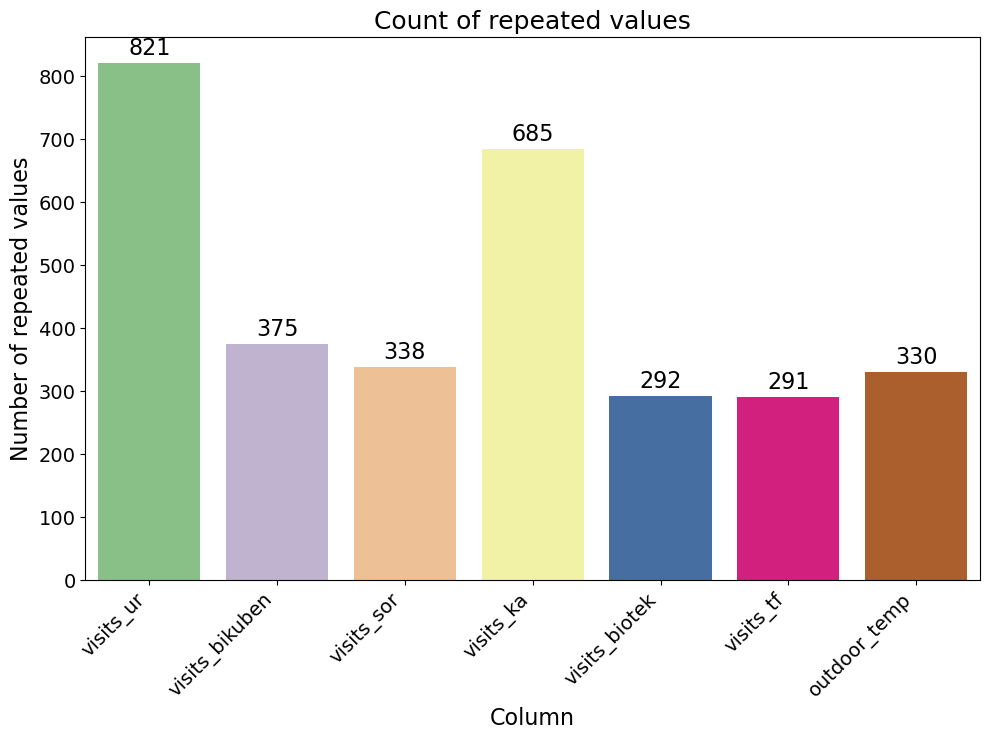

In [20]:
# find columns with missing values
missing_counts = df_imputed.isnull().sum()  # Get the count of missing values for each column
columns_with_missing = missing_counts[missing_counts > 0]  # Filter columns with at least one missing value
print(type(columns_with_missing))
columns_with_missing = columns_with_missing.reindex(['visits_ur', 'visits_bikuben', 'visits_sor', 
                                                     'visits_ka', 'visits_biotek', 'visits_tf', 'outdoor_temp'])

# plot the missing values count
plot = plt.figure(figsize=(10, 7.5))
ax = sns.barplot(x=columns_with_missing.index, y=columns_with_missing.values, palette='Accent', hue=columns_with_missing.index)

# show the number of missing values on top of each bar
for i, value in enumerate(columns_with_missing.values):
    ax.text(i, value + 5, str(value), ha='center', va='bottom', fontsize=16)  # Adjust `value + 5` for spacing

# plot
plt.title('Count of repeated values', fontsize=18)
plt.xlabel('Column', fontsize=16)
plt.ylabel('Number of repeated values', fontsize=16)
plt.tick_params(axis='both', labelsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout() 
plt.show()

plot.savefig("Columns with repeated values.png", dpi=300, bbox_inches="tight")

## Plot to show where to impute
The sequences of missing values/ repeated values are plotted

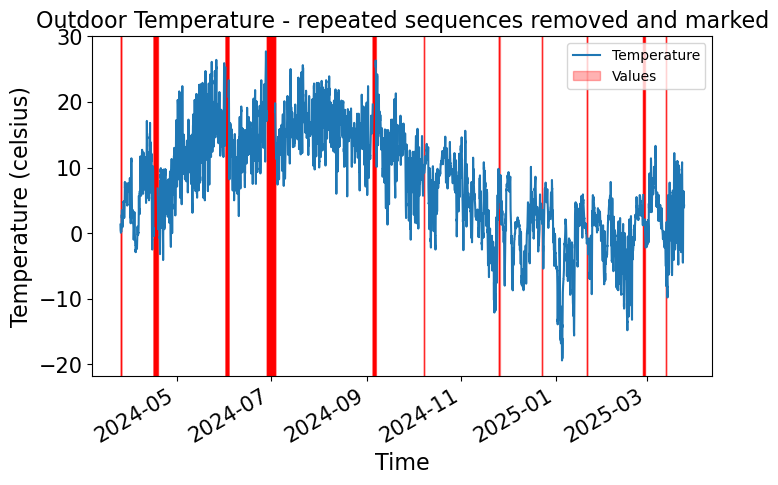

In [22]:
# quickplot
#df_imputed['outdoor_temp'].plot(title='Outdoor Temperature - repeated sequences set to NA', style='-', label='Temperature')

def find_missing_values(series):
    missing_indices = series.index[series.isna()]  # Get indices of missing values
    return missing_indices

# Find missing values
missing_indices = find_missing_values(df_imputed['outdoor_temp'])

# Plot the data
ax = df_imputed['outdoor_temp'].plot(title='Outdoor Temperature - repeated sequences removed and marked',style='-',label='Temperature',figsize=(8, 5))

ax.set_ylabel('Temperature (celsius)', fontsize=16)
ax.set_xlabel('Time', fontsize=16)
ax.tick_params(axis='both', labelsize=15)
ax.legend(loc='upper right', fontsize=16)
ax.set_title('Outdoor Temperature - repeated sequences removed and marked', fontsize=16)


# Mark missing values
for idx in missing_indices:
    plt.axvspan(idx, idx, color='red', alpha=0.3, label='Values')

# Add legend (avoid duplicate labels)
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))  # Remove duplicate labels
plt.legend(by_label.values(), by_label.keys())

plt.show()
plot.savefig("Repeated values marked for temperature.png", dpi=300, bbox_inches="tight")

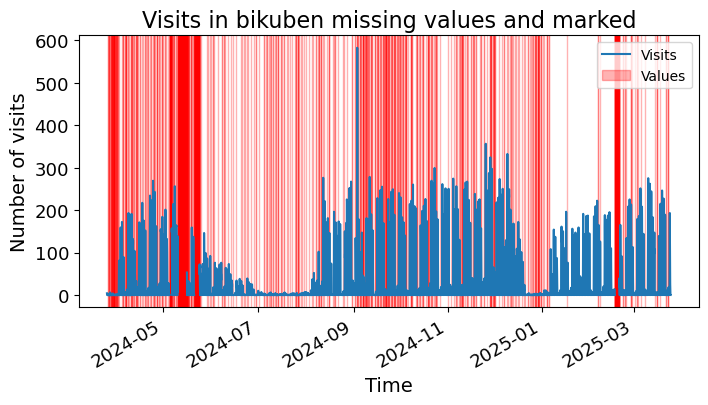

In [23]:
# Find missing values
missing_indices = find_missing_values(data['visits_bikuben'])

ax = data['visits_bikuben'].plot(title='Visits in bikuben missing values and marked',style='-',label='Visits',figsize=(8, 4))

ax.set_ylabel('Number of visits', fontsize=14)
ax.set_xlabel('Time', fontsize=14)
ax.tick_params(axis='both', labelsize=13)
ax.legend(loc='upper right', fontsize=14)
ax.set_title('Visits in bikuben missing values and marked', fontsize=16)

# Mark missing values
for idx in missing_indices:
    plt.axvspan(idx, idx, color='red', alpha=0.3, label='Values')

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

# Save the correct figure
fig = ax.get_figure()
fig.savefig("Missing values marked in red.png", dpi=300, bbox_inches="tight")
plt.show()

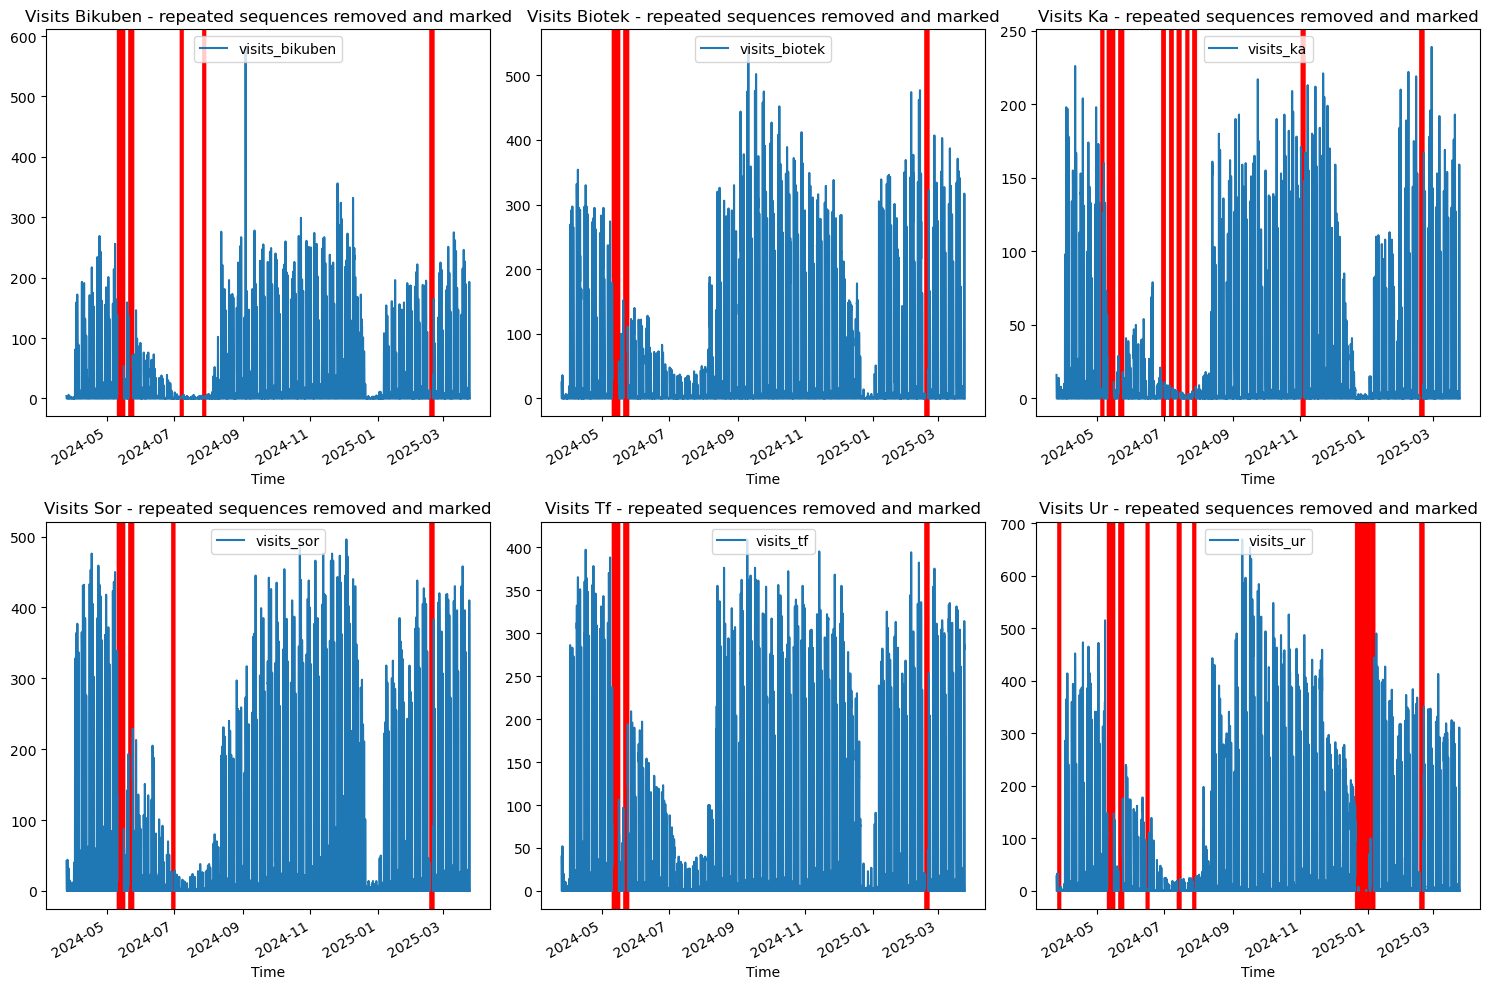

In [24]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, col in enumerate(columns_imp):
    ax = axes[i]
    
    # Plot the main time series
    df_imputed[col].plot(ax=ax, title=f'{col.replace("_", " ").title()} - repeated sequences removed and marked', style='-', label=col)

    # Find missing indices
    missing_indices = df_imputed.index[df_imputed[col].isna()]

    # Mark missing values with vertical red spans
    for idx in missing_indices:
        ax.axvspan(idx, idx, color='red', alpha=0.5)

    # Add legend
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))  # Remove duplicate labels
    ax.legend(by_label.values(), by_label.keys())

plt.tight_layout()
plt.show()
#fig.savefig("Repeated values marked.png", dpi=300, bbox_inches="tight")

In [25]:
#print(type(df_imputed))
#df_imputed = pd.DataFrame(df_imputed)
#df_imputed.columns

### Weekly mean imputation function

In [27]:
def impute_missing_values(df, column):
    missing_idx = df[df[column].isna()].index

    for idx in missing_idx:
        # Calculate the time stamps for one week before and after
        one_week_before = idx - pd.Timedelta(weeks=1)
        one_week_after = idx + pd.Timedelta(weeks=1)

        # Find valid values for the same hour in the weeks before and after
        before_value = None
        after_value = None

        # Look for a valid value in the week before
        current_before = one_week_before
        while before_value is None and current_before >= df.index.min():
            if not pd.isna(df.loc[current_before, column]):
                before_value = df.loc[current_before, column]
            else:
                current_before -= pd.Timedelta(weeks=1)

        # Look for a valid value in the week after
        current_after = one_week_after
        while after_value is None and current_after <= df.index.max():
            if not pd.isna(df.loc[current_after, column]):
                after_value = df.loc[current_after, column]
            else:
                current_after += pd.Timedelta(weeks=1)

        # Impute the missing value as the mean of the valid before and after values
        if before_value is not None and after_value is not None:
            df.at[idx, column] = (before_value + after_value) / 2
        elif before_value is not None:
            df.at[idx, column] = before_value
        elif after_value is not None:
            df.at[idx, column] = after_value

    return df

In [28]:
first_date = df_imputed.index.min()
last_date = df_imputed.index.max()

data_w_imputed_visits = df_imputed.loc[first_date:last_date].copy()
data_w_imputed_visits = data_w_imputed_visits[~data_w_imputed_visits.index.duplicated(keep='first')]

data_w_imputed_visits = impute_missing_values(data_w_imputed_visits, 'visits_bikuben')
data_w_imputed_visits = impute_missing_values(data_w_imputed_visits, 'visits_biotek')
data_w_imputed_visits = impute_missing_values(data_w_imputed_visits, 'visits_ka')
data_w_imputed_visits = impute_missing_values(data_w_imputed_visits, 'visits_sor')
data_w_imputed_visits = impute_missing_values(data_w_imputed_visits, 'visits_tf')
data_w_imputed_visits = impute_missing_values(data_w_imputed_visits, 'visits_ur')
data_w_imputed_visits = impute_missing_values(data_w_imputed_visits, 'outdoor_temp')


#data_w_imputed_visits = data_w_imputed_visits.ffill()
data_w_imputed_visits.isnull().sum()

#data_w_imputed_visits
#columns_imp = ['visits_bikuben', 'visits_biotek', 'visits_ka', 'visits_sor', 'visits_tf', 'visits_ur']
#             ['visits_bikuben', 'visits_biotek', 'visits_ka', 'visits_sor', 'visits_tf', 'visits_ur', 'outdoor_temp']


el_ur                    0
district_heat_ur         0
outdoor_temp             0
bookings_ur              0
visits_ur                0
district_heat_bikuben    0
el_bikuben               0
bookings_bikuben         0
visits_bikuben           0
el_sor                   0
district_heat_sor        0
bookings_sor             0
visits_sor               0
district_heat_ka         0
el_ka                    0
bookings_ka              0
visits_ka                0
el_biotek                0
district_heat_biotek     0
bookings_biotek          0
visits_biotek            0
el_tf                    0
district_heat_tf         0
bookings_tf              0
visits_tf                0
dtype: int64

## Result of imputation
Show one plot that shows all and one plot zoomed in (the one i already have for TF

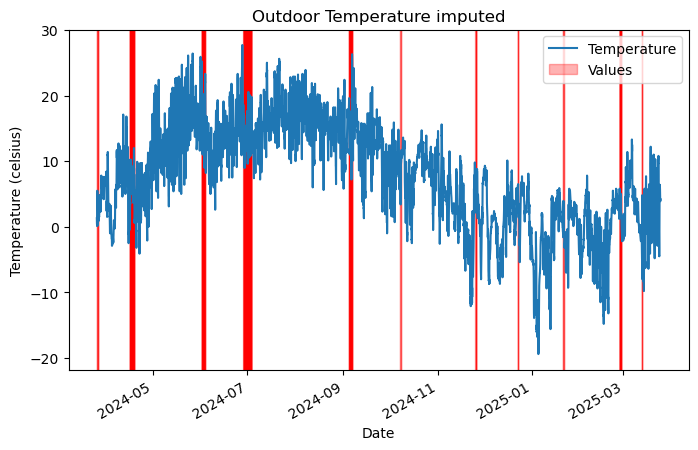

In [30]:
# missing indices of dataframe before imputation
missing_indices = find_missing_values(df_imputed['outdoor_temp'])

# Plot the data
plot = plt.figure(figsize=(8, 5))
data_w_imputed_visits['outdoor_temp'].plot(title='Outdoor Temperature imputed', style='-', label='Temperature')
plt.ylabel('Temperature (celsius)')
plt.xlabel('Date')

# Mark missing values
for idx in missing_indices:
    plt.axvspan(idx, idx, color='red', alpha=0.3, label='Values')

# Add legend (avoid duplicate labels)
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

plt.show()
#plot.savefig("Outdoor temp imputed.png", dpi=300, bbox_inches="tight")

In [31]:
datetime_ranges = [
    (data.index[6482], data.index[6541]),
    (data.index[6551], data.index[6711]),
    (data.index[6718], data.index[6782]),
    (data.index[6818], data.index[6878]),
]
# Now substitute based on datetime ranges
for start_time, end_time in datetime_ranges:
    data_w_imputed_visits.loc[start_time:end_time, 'visits_ur'] = data_w_imputed_visits.loc[start_time:end_time, 'visits_ka'].values


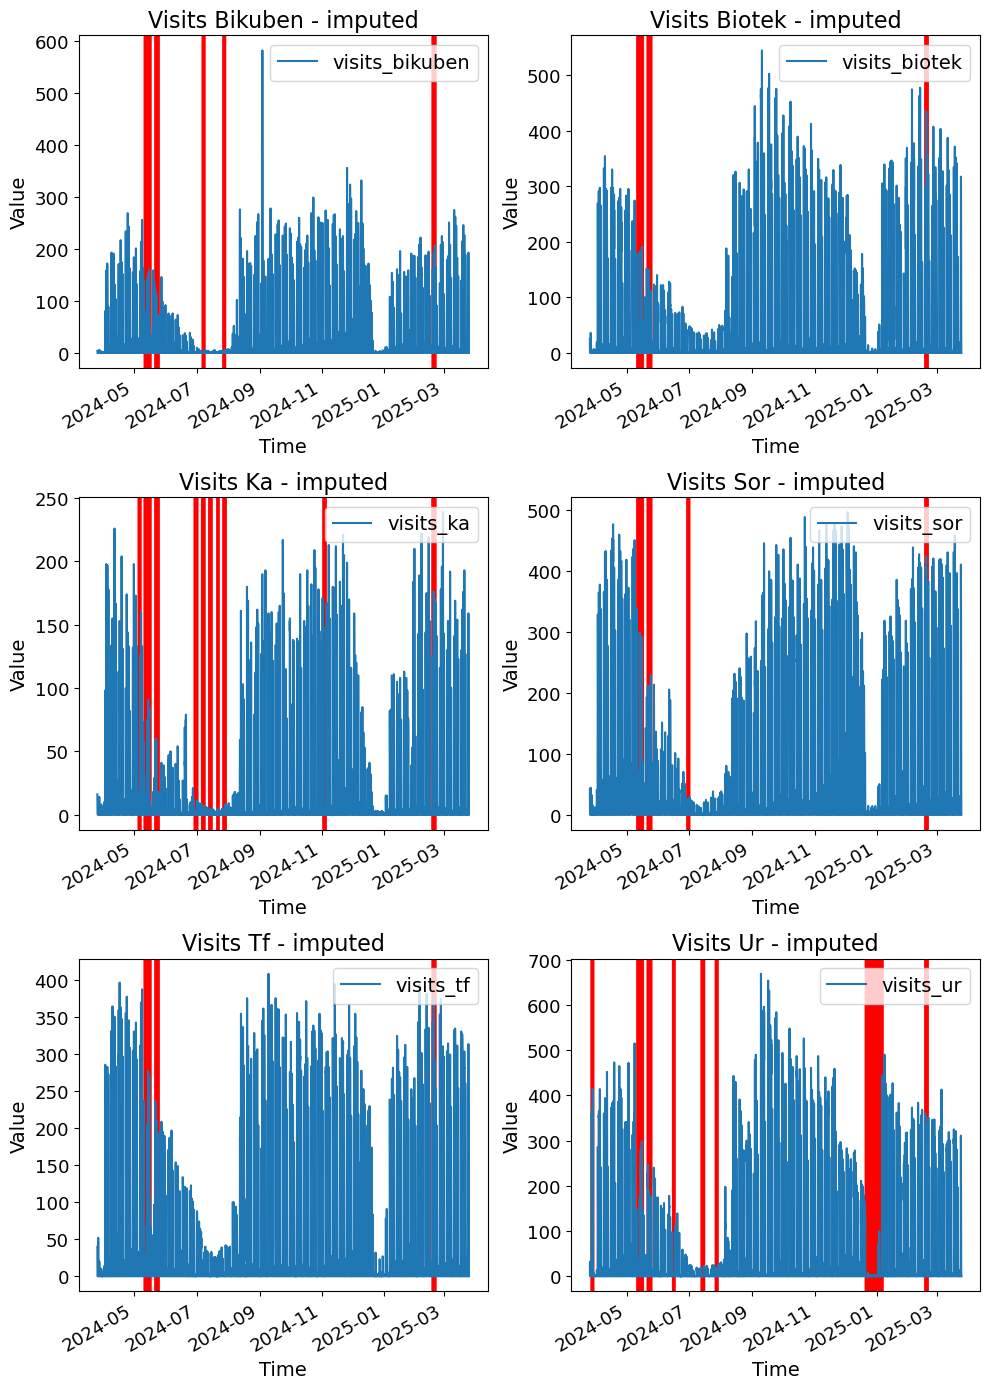

In [32]:
#fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig, axes = plt.subplots(3, 2, figsize=(10, 14))
axes = axes.flatten()

for i, col in enumerate(columns_imp):
    ax = axes[i]
    
    # Plot the main time series
    data_w_imputed_visits[col].plot(ax=ax, style='-', label=col)
    ax.set_title(f'{col.replace("_", " ").title()} - imputed', fontsize=16)
    
    # Label axes
    ax.set_xlabel("Time", fontsize=14)
    ax.set_ylabel("Value", fontsize=14)
    ax.tick_params(axis='both', labelsize=13)

    # Find missing indices
    missing_indices = df_imputed.index[df_imputed[col].isna()]

    # Mark missing values with vertical red spans
    for idx in missing_indices:
        ax.axvspan(idx, idx, color='red', alpha=0.5)

    # Add legend
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))  # Remove duplicate labels
    ax.legend(by_label.values(), by_label.keys(), loc='upper right', fontsize=14)

plt.tight_layout()
plt.show()
#fig.savefig("Visits imputed.png", dpi=300, bbox_inches="tight")

In [33]:
#fig.savefig("Visits imputed.png", dpi=300, bbox_inches="tight")

In [34]:
#data_w_imputed_visits.to_csv('data_imputed_one_year.csv')
#data_w_imputed_visits.to_csv('data_imputed.csv')

### Testing the function on single columns

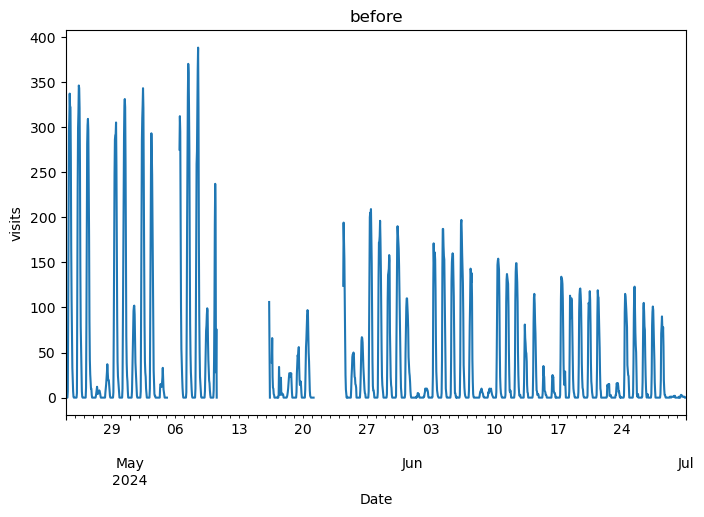

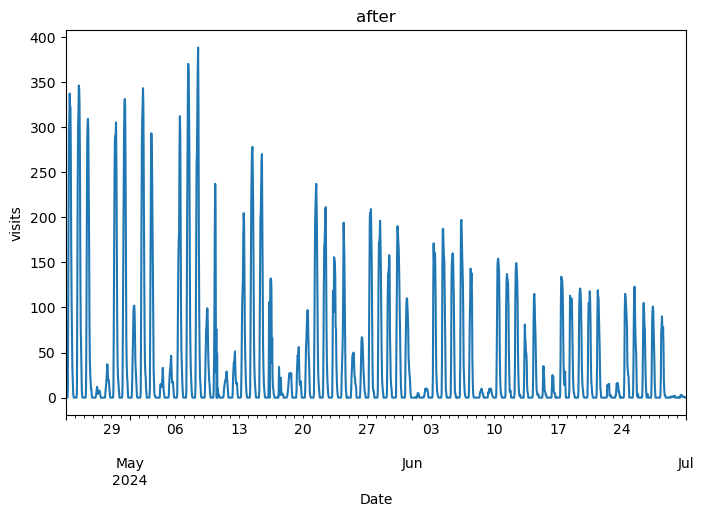

In [36]:
data = pd.read_csv('all_building_data.csv')
data['Time'] = pd.to_datetime(data['Time'])
data = data.set_index('Time')

test = data[['visits_tf']].loc["2024-04-24 00:00:00": "2024-07-01 00:00:00"]

plt.figure(figsize=(8, 5))
test['visits_tf'].plot(title='before', style='-', label='visits')
plt.ylabel('visits')
plt.xlabel('Date')
plt.show()

missing_indices = test[test['visits_tf'].isna()].index


# Apply the imputation function to the 'visits_tf' column
test = impute_missing_values(test, 'visits_tf')

plt.figure(figsize=(8, 5))
test['visits_tf'].plot(title='after', style='-', label='visits')
plt.ylabel('visits')
plt.xlabel('Date')
plt.show()

## Correlation Analysis

In [38]:
data = data_w_imputed_visits.copy()
# Define building names and their respective columns
buildings = {'ur': ['el_ur', 'district_heat_ur', 'bookings_ur', 'visits_ur'],
            'bikuben': ['el_bikuben', 'district_heat_bikuben', 'bookings_bikuben', 'visits_bikuben'],
            'sor': ['el_sor', 'district_heat_sor', 'bookings_sor', 'visits_sor'],
            'ka': ['el_ka', 'district_heat_ka', 'bookings_ka', 'visits_ka'],
            'biotek': ['el_biotek', 'district_heat_biotek', 'bookings_biotek', 'visits_biotek'],
            'tf': ['el_tf', 'district_heat_tf', 'bookings_tf', 'visits_tf']}

# Add outdoor temperature to each building's data
for building in buildings:
    buildings[building].append('outdoor_temp')

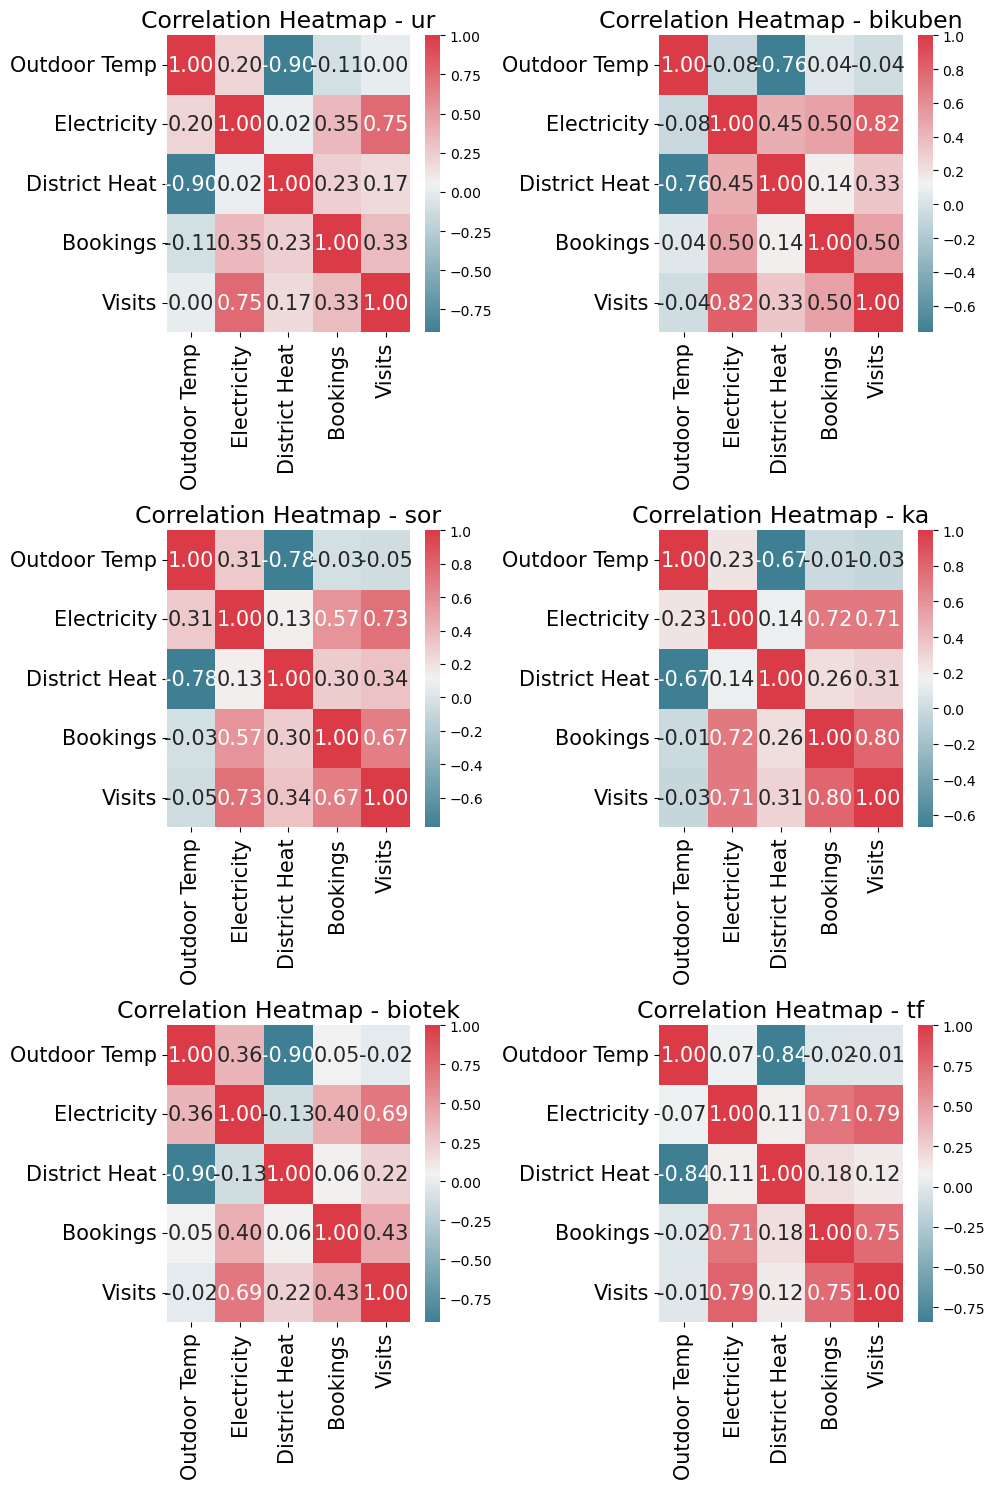

In [39]:
def plot_correlation_heatmaps(data, buildings, variable_order):
    fig, axes = plt.subplots(3, 2, figsize=(10, 15))
    axes = axes.flatten()

    for i, (building, columns) in enumerate(buildings.items()):
        # Select relevant columns and calculate correlation
        building_data = data[columns]
        building_data.columns = ['Electricity', 'District Heat', 'Bookings', 'Visits', 'Outdoor Temp']
        corr = building_data.corr().loc[variable_order, variable_order]

        # Plot heatmap
        sns.heatmap(corr, annot=True, annot_kws={'size': 15}, fmt=".2f", cmap=sns.diverging_palette(220, 10, as_cmap=True), ax=axes[i])
        axes[i].set_title(f'Correlation Heatmap - {building}', fontsize=17)
        axes[i].tick_params(axis='both', labelsize=15)

    plt.tight_layout()
    plt.show()
    
    fig.savefig("Correlation heatmaps.png", dpi=300, bbox_inches="tight")

# Define the order of variables for the heatmap
variable_order = ['Outdoor Temp', 'Electricity', 'District Heat', 'Bookings', 'Visits']

# Plot heatmaps for all buildings
plot_correlation_heatmaps(data, buildings, variable_order)

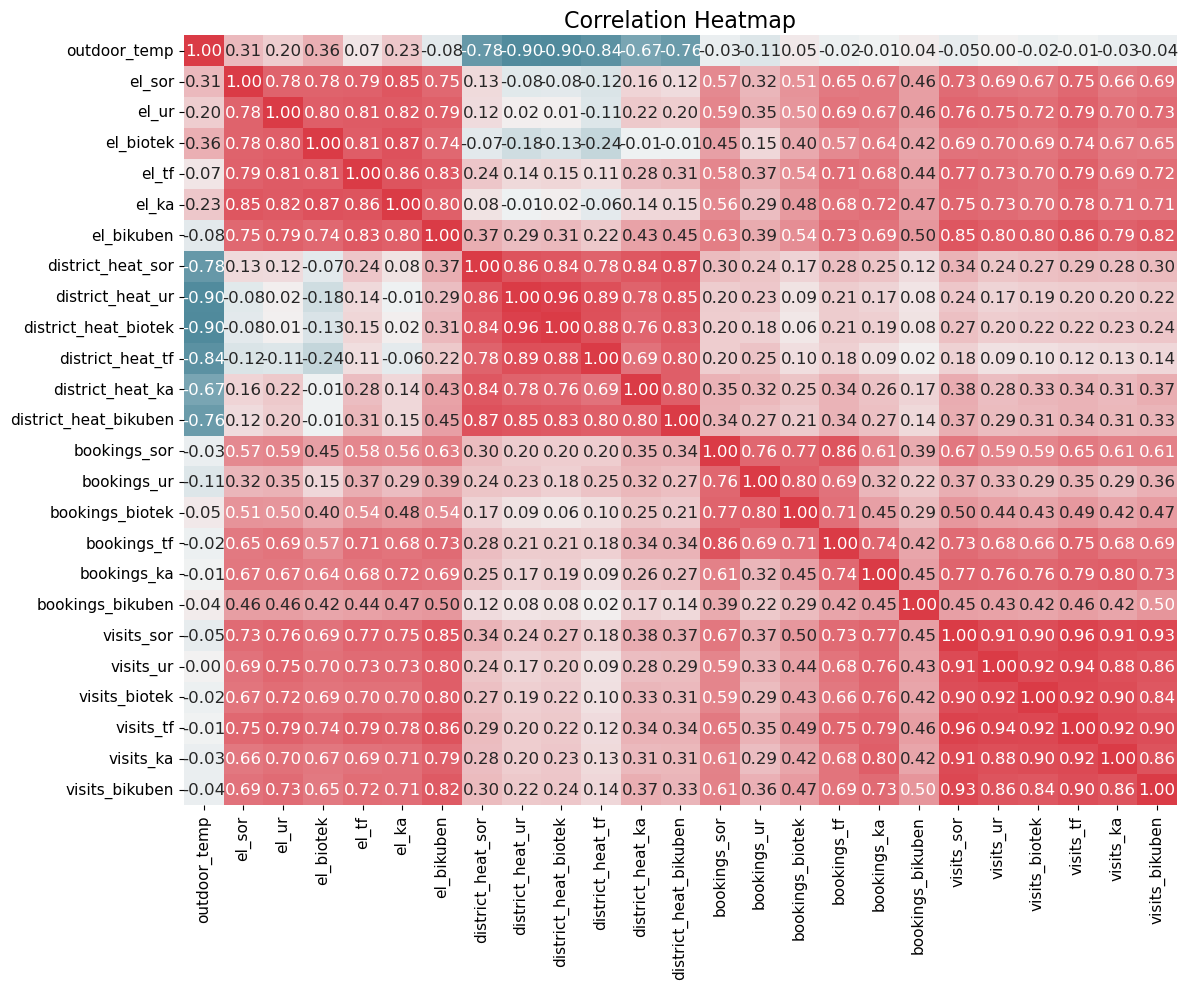

In [40]:
correlation_full = data.corr()
#mask = np.triu(correlation_full)
desired_order = ['outdoor_temp', 'el_sor', 'el_ur', 'el_biotek', 'el_tf', 'el_ka', 'el_bikuben',
                'district_heat_sor', 'district_heat_ur', 'district_heat_biotek', 'district_heat_tf', 
                'district_heat_ka', 'district_heat_bikuben',
                'bookings_sor', 'bookings_ur', 'bookings_biotek', 'bookings_tf', 'bookings_ka', 
                'bookings_bikuben',
                'visits_sor', 'visits_ur', 'visits_biotek', 'visits_tf', 'visits_ka', 'visits_bikuben']

# Reorder the correlation matrix
correlation_ordered = correlation_full.loc[desired_order, desired_order]

# Plot heatmap
fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(correlation_ordered, annot=True, annot_kws={'size': 12}, 
            fmt=".2f", vmin=-1, vmax=1, center=0, 
            cmap=sns.diverging_palette(220, 10, as_cmap=True), cbar=False, square=False, ax=ax) 
plt.tick_params(axis='both', labelsize=11)
plt.title("Correlation Heatmap", fontsize=16)
plt.tight_layout()
plt.show()

fig.savefig("Correlation heatmap - all buildings in one matrix.png", dpi=300, bbox_inches="tight")

### Extra plots

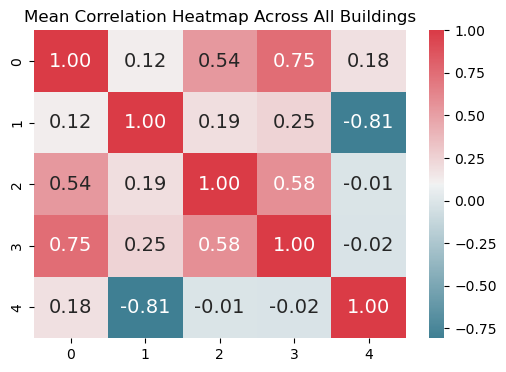

In [42]:
def compute_mean_correlation(data, buildings, variable_order):
    correlation_matrices = []

    for building, columns in buildings.items():
        # Select relevant columns and calculate correlation
        building_data = data[columns]
        building_data.columns = ['Outdoor Temp', 'Electricity', 'District Heat', 'Bookings', 'Visits']
        corr = building_data.corr().loc[variable_order, variable_order]
        correlation_matrices.append(corr)

    # Compute the mean correlation matrix
    mean_corr = np.mean(correlation_matrices, axis=0)
    return mean_corr

# Compute the mean correlation matrix
mean_corr = compute_mean_correlation(data, buildings, variable_order)

# Plot the mean correlation heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(mean_corr, annot=True, annot_kws={'size': 14}, fmt=".2f", cmap=sns.diverging_palette(220, 10, as_cmap=True))
plt.title('Mean Correlation Heatmap Across All Buildings')
plt.show()

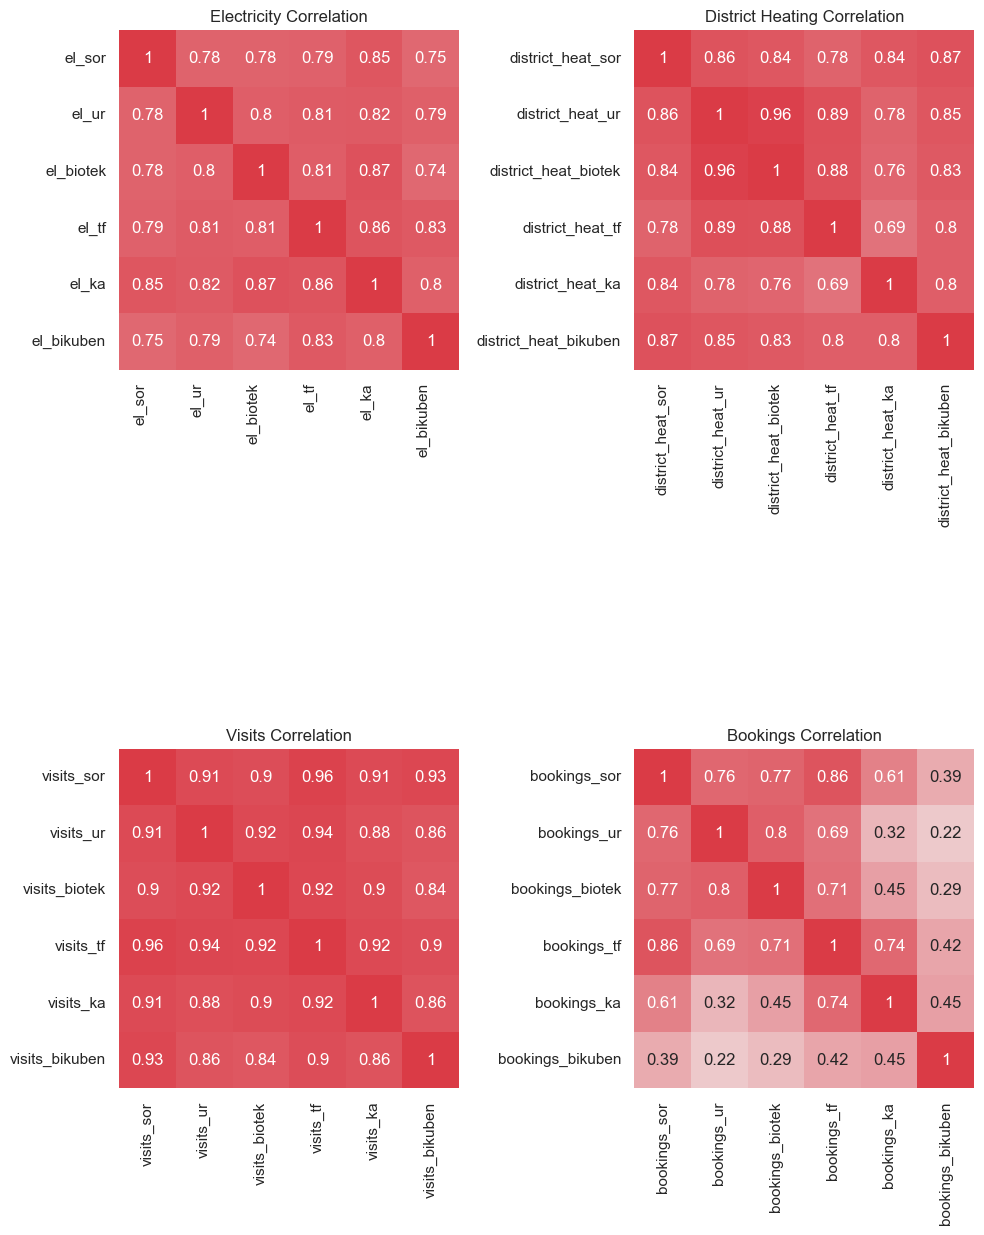

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style
sns.set(style="white")

# Select the relevant columns
el_cols = ['el_sor', 'el_ur', 'el_biotek', 'el_tf', 'el_ka', 'el_bikuben']
heat_cols = ['district_heat_sor', 'district_heat_ur', 'district_heat_biotek', 'district_heat_tf', 'district_heat_ka', 'district_heat_bikuben']
visits_cols = ['visits_sor', 'visits_ur', 'visits_biotek', 'visits_tf', 'visits_ka', 'visits_bikuben']
bookings_cols = ['bookings_sor', 'bookings_ur', 'bookings_biotek', 'bookings_tf', 'bookings_ka', 'bookings_bikuben']

# Create correlation matrices
correlation_el = data[el_cols].corr()
correlation_heat = data[heat_cols].corr()
correlation_visits = data[visits_cols].corr()
correlation_bookings = data[bookings_cols].corr()

# Set up a 2x2 subplot grid
fig, axes = plt.subplots(2, 2, figsize=(10, 15))

# Plot each heatmap
sns.heatmap(correlation_el, annot=True, vmin=-1, vmax=1, center=0, 
            cmap=sns.diverging_palette(220, 10, as_cmap=True), square=True, ax=axes[0,0], cbar=False)
axes[0,0].set_xticklabels(axes[0,0].get_xticklabels(), rotation=90, ha='right')
axes[0,0].set_yticklabels(axes[0,0].get_yticklabels(), rotation=0)
axes[0,0].set_title('Electricity Correlation')

sns.heatmap(correlation_heat, annot=True, vmin=-1, vmax=1, center=0, 
            cmap=sns.diverging_palette(220, 10, as_cmap=True), square=True, ax=axes[0,1], cbar=False)
axes[0,1].set_title('District Heating Correlation')

sns.heatmap(correlation_visits, annot=True, vmin=-1, vmax=1, center=0, 
            cmap=sns.diverging_palette(220, 10, as_cmap=True), square=True, ax=axes[1,0], cbar=False)
axes[1,0].set_title('Visits Correlation')

sns.heatmap(correlation_bookings, annot=True, vmin=-1, vmax=1, center=0, 
            cmap=sns.diverging_palette(220, 10, as_cmap=True), square=True, ax=axes[1,1], cbar=False)
axes[1,1].set_title('Bookings Correlation')

# Layout adjustment
plt.tight_layout()
plt.show()